In [1]:
%matplotlib notebook
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import defaultdict
import time
import pandas as pd
import sys

In [2]:
NUM_BOTS = 7
NUM_COMPS = 8
stock_ids = ['AAPL', 'AMD', 'AMZN', 'CSCO', 'IBM', 'INTC', 'MSFT', 'NVDA']

samps = 100

data_dict = {f'bot_{i}':np.random.random_sample(size = (samps, NUM_COMPS)).tolist() for i in range(NUM_BOTS)}
data_dict['year'] = list(range(samps))
data_dict['true_prices'] = np.random.random_sample(size = (samps, NUM_COMPS)).tolist()
data_dict['vol_adj'] = np.random.random_sample(size = (samps, NUM_COMPS)).tolist()
df = pd.DataFrame(data_dict, index = np.arange(0, 100))



In [3]:
def unpickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

class TradeBot:
    
    def __init__(self, bot_number, current_prices, holdings):
        assert isinstance(current_prices, np.ndarray)
        assert isinstance(holdings, np.ndarray)
        np.seterr(divide = 'ignore')
        self.bot_number = bot_number
        self.prices = current_prices
        self.holdings = holdings
        self.cash = 10000
        self.worth = self.get_worth()
        
    def update_holdings(self, buy_sells):
        new_holdings = np.add(self.holdings, buy_sells)
        self.holdings = new_holdings
        
    def get_worth(self):
        return sum(np.multiply(self.holdings, self.prices)) - self.cash
    
    def calculate_buy_sell(self, pred_prices):
        pct_price_change = np.divide(np.subtract(pred_prices,
                                                 self.prices),
                                     self.prices)
        # sell or buy based on % expected change relative to holdings
        preferred_actions = np.multiply(pct_price_change, self.holdings)
        
        split_worth = (self.worth + self.cash) / self.prices.shape[0]
        buy_sell = np.array([self.clip_transact(p, i,
                            split_worth) for i, p in enumerate(preferred_actions)])
        return buy_sell
    
    def clip_transact(self, action,i, max_spend):
        # prevent spending more than a uniform portion of its worth
        if action > 0:
            stock_price = self.prices[i]
            
            # lower volume to max allotment if needed
            buy_cost = min(stock_price*action, max_spend)
            return buy_cost/stock_price
        # prevent bot from selling more than it owns
        else:
            current_stock = self.holdings[i]
            return min(current_stock, action)
        
    def update_self(self, pred_prices, true_prices):
        buy_sell = self.calculate_buy_sell(pred_prices)
        self.update_holdings(buy_sell)
        
        # buy and sell with previous prices
        cash_loss = sum([b_s*p for b_s, p in zip(buy_sell, self.prices)])
        self.cash -= cash_loss
        
        # update prices and worth
        self.prices = true_prices
        self.worth = self.get_worth()

class Adversary:
    
    def __init__(self, current_prices):
        assert isinstance(current_prices, np.ndarray)
        np.seterr(divide = 'ignore')
        self.prices = current_prices
        self.cash = 0
        self.holdings = np.zeros_like(current_prices)
        self.worth = self.get_worth()
        self.worth_history = [self.worth]
        
    def update_holdings(self, buy_sells):
        new_holdings = np.add(self.holdings, buy_sells)
        self.holdings = new_holdings
        
    def get_worth(self):
        return sum(np.multiply(self.holdings, self.prices)) + self.cash
        
    def update_self(self, volume_adjusts, true_prices):
        price_changes = np.subtract(true_prices, self.prices)
        buy_sell = np.array([v if p > 0 else -v for p, v in zip(price_changes, volume_adjusts)])
        self.update_holdings(buy_sell)
        
        # buy and sell with previous prices
        cash_loss = sum([b_s*p for b_s, p in zip(buy_sell, self.prices)])
        self.cash -= cash_loss
        
        # update prices
        self.prices = true_prices
        self.worth = self.get_worth()
        self.worth_history.append(self.worth)
        return buy_sell

In [4]:
pred_dict = unpickle('pred_data.p')

In [7]:
(150*.5)/60

1.25

<IPython.core.display.Javascript object>


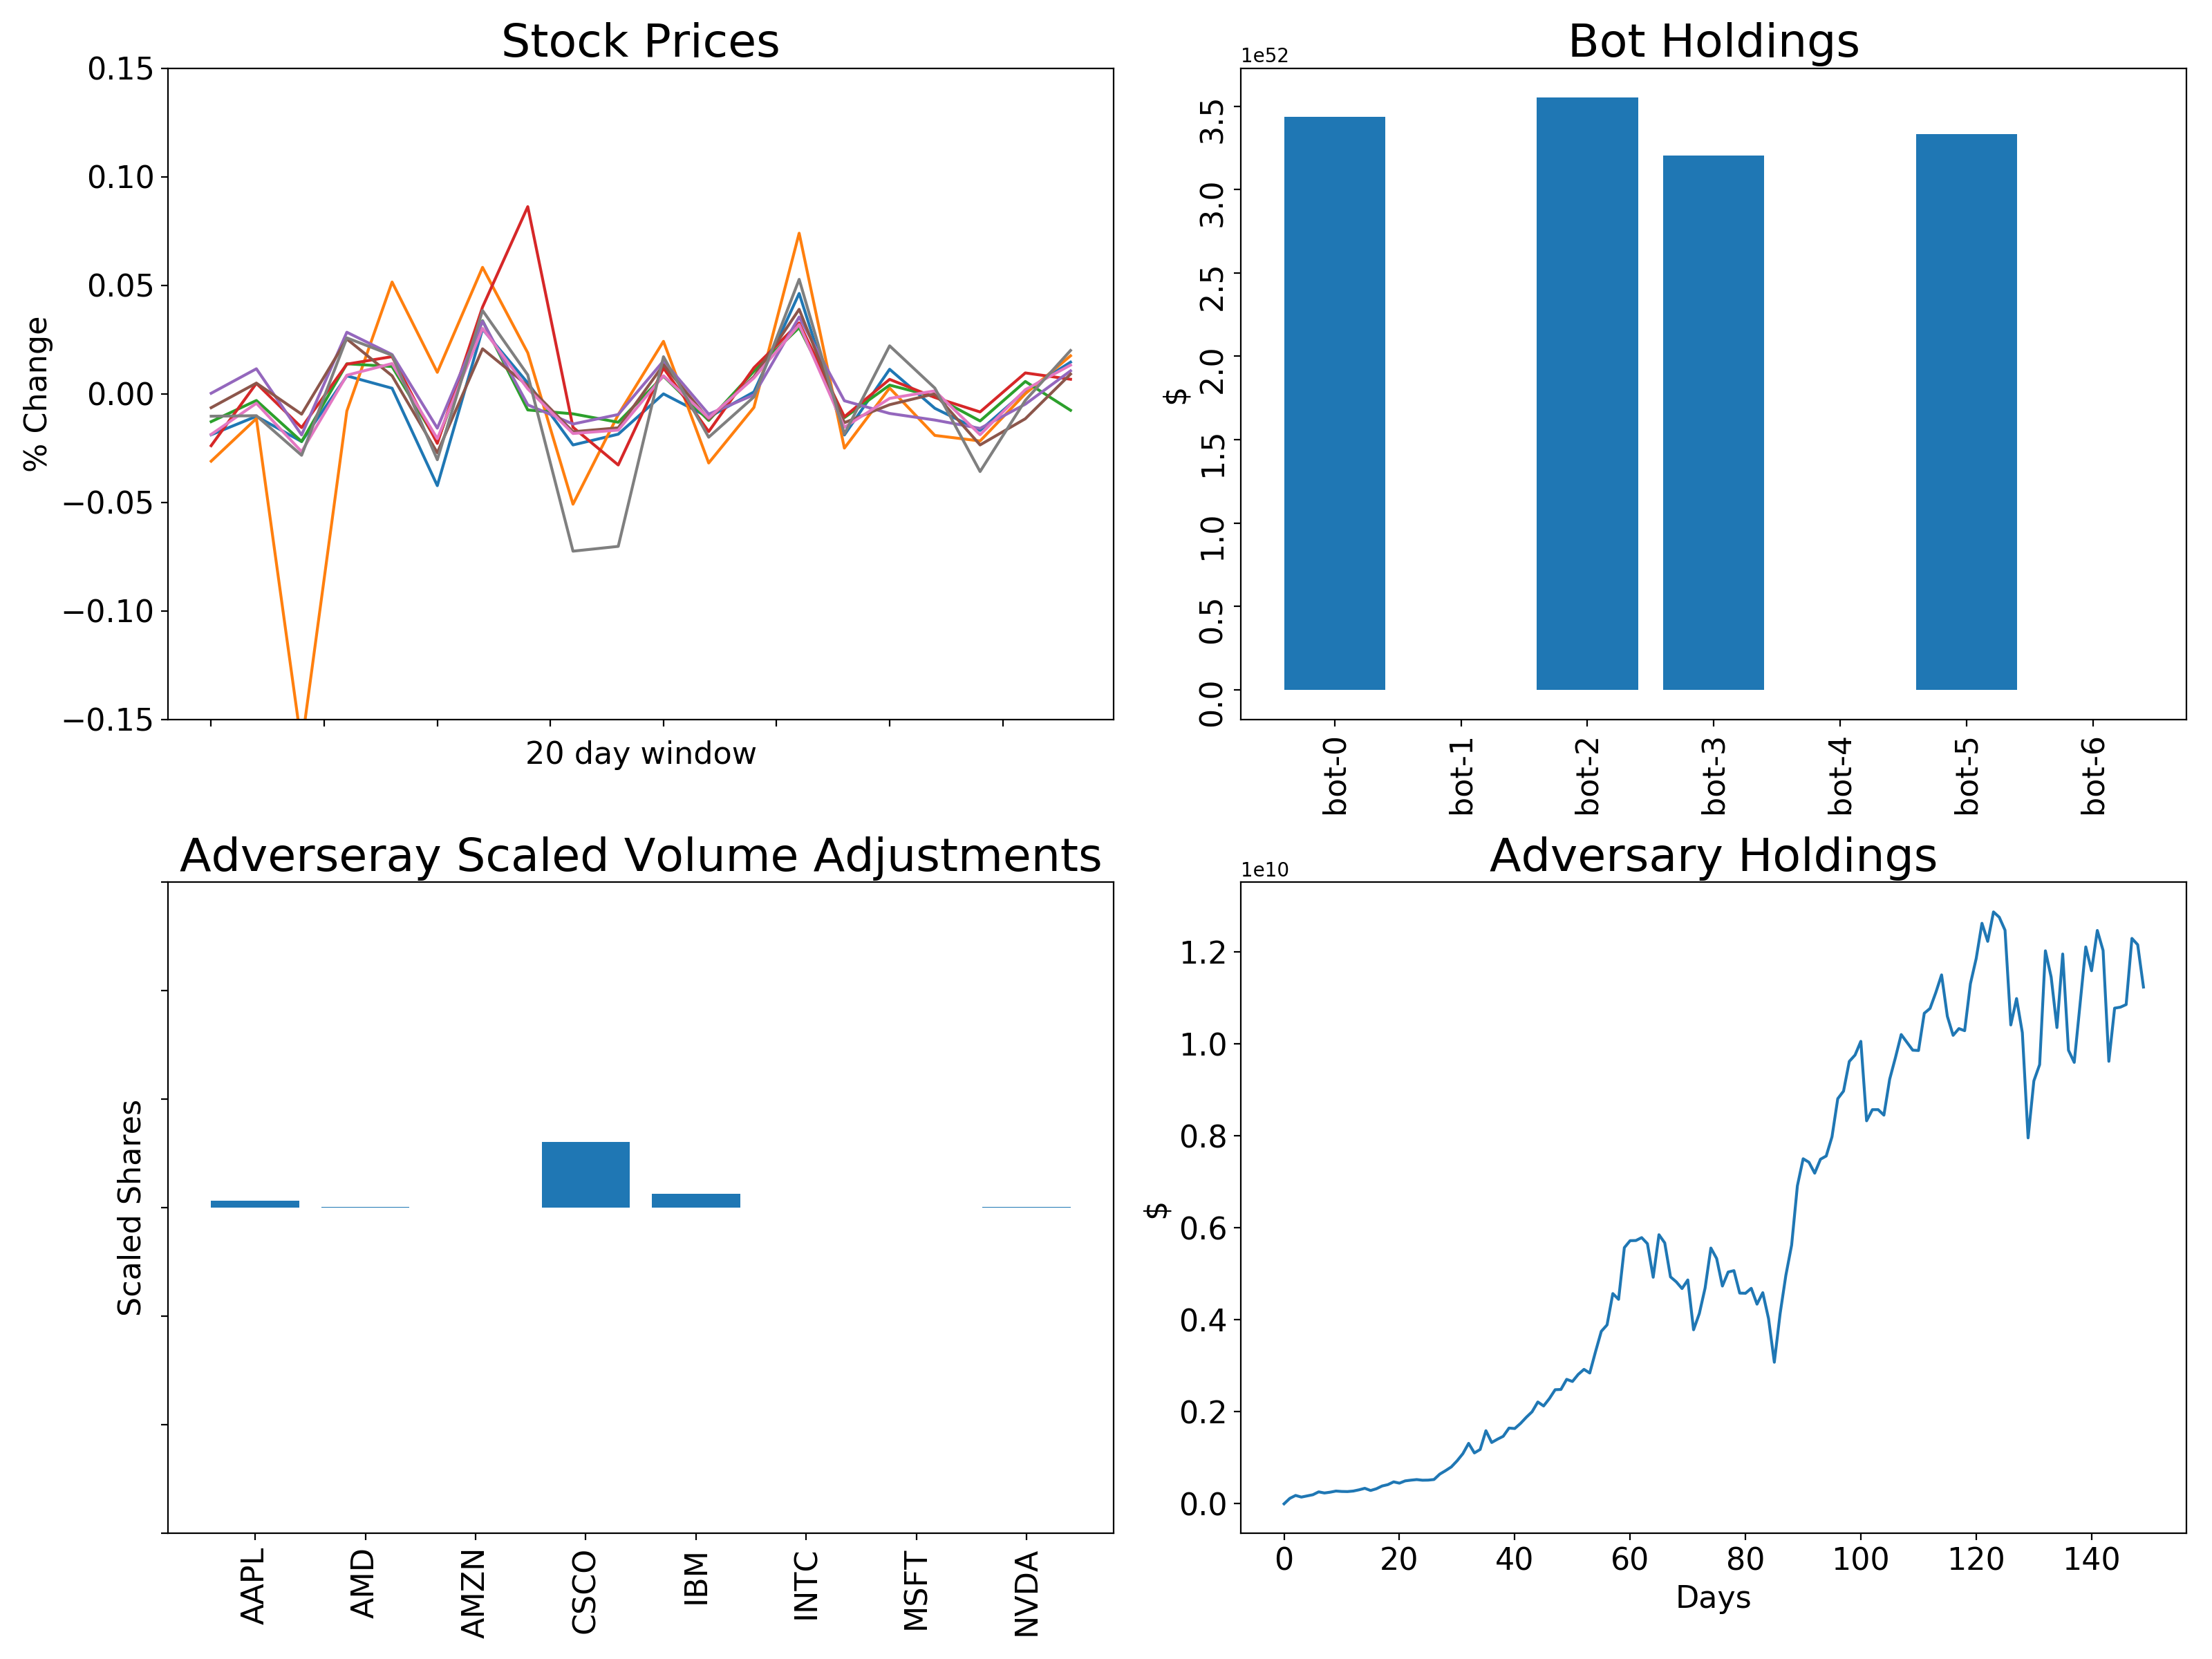

In [14]:
plt.rcParams['figure.figsize'] = [16, 12]

ax_fs = 16
ti_fs = 24
price_window = 20
eps = sys.float_info.epsilon

fig, ax = plt.subplots(2,2)

fig.canvas.draw()

market_history = {stock: [[0,0]]*price_window for stock in stock_ids}
bots = {}
r = pred_dict[0]
adv = Adversary(np.array(r['prices']))
last_vol_adj = r['scaled_vol_adj']

for b in range(NUM_BOTS):
    
    bots[b] = TradeBot(b, np.array(r['prices']), holdings = np.array([10000]*8))

x_labs = [f'bot-{b}' for b in range(NUM_BOTS)]
for i in range(1,150):
    ax[1][1].clear()
    ax[0][1].clear()
    ax[0][0].clear()
    ax[1][0].clear()
    r = pred_dict[i]
    
    # Put a legend below current axis
    
    # market price plot
    for stock_ix, (stock, price) in enumerate(zip(stock_ids,r['prices'])):
        last_price = market_history[stock][-1][1]
        price_pct_change = (last_price - price)/(last_price + eps)
        market_history[stock].append([price_pct_change, price])
        ax[0][0].plot([p[0] for p in market_history[stock][-price_window:]], label = stock)
    
    ax[0][0].set_title('Stock Prices', fontsize = ti_fs)
    ax[0][0].set_ylabel('% Change', fontsize = ax_fs)
    ax[0][0].set_xlabel(f"{price_window} day window", fontsize = ax_fs)
    ax[0][0].tick_params(axis='y', which='major', labelsize=ax_fs)
    ax[0][0].set_xticklabels([])
    ax[0][0].set_ylim([-.15, .15])
    
#     handles, labels = ax[0][0].get_legend_handles_labels()
#     fig.legend(handles, labels, loc='lower center', ncol = NUM_COMPS, prop={'size': 15})

    adv.update_self(np.array(r['adv_vols']), np.array(r['prices']))
    for b in range(NUM_BOTS):
        bots[b].update_self(np.array(r['bots'][b]), np.array(r['prices']))
    
    # adversary's net worth
    ax[1][1].plot(adv.worth_history)
    ax[1][1].set_title('Adversary Holdings', fontsize = ti_fs)
    ax[1][1].set_ylabel('$', fontsize = ax_fs)
    ax[1][1].set_xlabel(f"Days", fontsize = ax_fs)
    ax[1][1].tick_params(axis='both', which='major', labelsize=ax_fs)
        
    
    # bot net worth
    bot_worth = [bots[b].worth for b in range(NUM_BOTS)]
    ax[0][1].bar(x = x_labs, height = bot_worth)
    ax[0][1].set_title('Bot Holdings', fontsize = ti_fs)
    ax[0][1].set_ylabel('$', fontsize = ax_fs)
    ax[0][1].tick_params(axis='both', which='major', labelsize=ax_fs, rotation = 90)
    
    # adversary adjustments
    changed_adj = [l - c for c,l in zip(r['scaled_vol_adj'], last_vol_adj)]
    ax[1][0].bar(x = stock_ids, height = changed_adj)
    ax[1][0].set_title('Adverseray Scaled Volume Adjustments', fontsize = ti_fs)
    ax[1][0].set_ylabel('Scaled Shares', fontsize = ax_fs)
    ax[1][0].tick_params(axis='both', which='major', labelsize=ax_fs, rotation = 90)
    last_vol_adj = r['scaled_vol_adj']
    ax[1][0].set_yticklabels([])
    ax[1][0].set_ylim([-.00003,.00003])
    
    plt.tight_layout()
    
    fig.canvas.draw()
    
    time.sleep(.6)
